# Volatility smile option pricing model

We implement an option pricing model based on a quadratic volatility smile. The main reference is "The Volatility Smile" by Derman and Miller (Wiley 2016).



## Set-up

In [1]:
from scipy.stats import norm
import scipy.stats
from math import log, exp, sqrt
from matplotlib import pyplot as plt

def relu(x):
    return max(0,x)

We define a function computing the Black-Scholes formula.

In [2]:
## Black-Scholes

Norm = scipy.stats.norm.cdf

def black_scholes_formula(
        spot: float, 
        strike: float, 
        volatility: float, 
        time_to_expiry: float,
        interest_rate = 0.0, 
        option_type = "call"
    ):
    assert option_type == "call" or option_type == "put", "Invalid option type; must be 'call' or 'put'"
    dplus = (log(spot/strike) + (interest_rate + (volatility**2)*0.5)*time_to_expiry)/(volatility*sqrt(time_to_expiry))
    dminus = (log(spot/strike) + (interest_rate - (volatility**2)*0.5)*time_to_expiry)/(volatility*sqrt(time_to_expiry))
    if option_type == "call":
        return spot*Norm(dplus) - strike*exp(-interest_rate*time_to_expiry)*Norm(dminus)
    else:
        return strike*exp(-interest_rate*time_to_expiry)*Norm(-dminus) - spot*Norm(-dplus)

### Classes

The first classes we define are for market conditions and for options

In [3]:
class MarketConditions:
    def __init__(self, spot, interest_rate) -> None:
        self.spot = spot
        self.interest_rate = interest_rate


class OptionClass:
    def __init__(self, strike: float, time_to_expiry: float, option_type: str) -> None:
        assert option_type == "call" or option_type == "put", "Option type must be 'call' or 'put'"
        self.strike = strike
        self.time_to_expiry = time_to_expiry
        self.option_type = option_type

    def value_at_expiration(self, spot_at_expiry: float) -> float:
        if self.option_type == "call":
            return max(0, spot_at_expiry - self.strike)
        else:
            return max(0, self.strike - spot_at_expiry)

Next, we define a class for the Black Scholes model.

In [4]:
class BlackScholesModel:
    def __init__(self, volatility) -> None:
        assert volatility > 0, "Volatility must be positive"
        self.volatility = volatility

    def pricing_function(self, conditions: MarketConditions, option: OptionClass) -> float:
        return black_scholes_formula(
            spot=conditions.spot, 
            strike=option.strike,
            volatility=self.volatility,
            time_to_expiry=option.time_to_expiry, 
            interest_rate=conditions.interest_rate,
            option_type=option.option_type
        )

We also have a class for the volatility smile model.

In [5]:
class VolSmileModel:
    def __init__(self, atm_vol: float, skew: float, curvature: float) -> None:
        assert atm_vol > 0, "Volatility must be positive"
        assert skew*skew - 4*atm_vol*curvature <= 0, "Invalid parameters"
        self.atm_vol = atm_vol
        self.skew = skew
        self.curvature = curvature

    def vol_smile_function(self, x):
        if -3 < x < 3:
            return self.atm_vol + self.skew*x + self.curvature*x*x
        elif x <-3:
            return self.atm_vol + self.skew*(-3) + self.curvature*(-3)*(-3) + (self.skew + 2*self.curvature*(-3))*(x - (-3))
        elif x > 3:
            return self.atm_vol + self.skew*(3) + self.curvature*(3)*(3) + (self.skew + 2*self.curvature*(3))*(x - 3)

    def plot_smile(self, min_d1=-4, max_d1=4, num_samples=100):
        step_size = (max_d1 - min_d1 )/num_samples
        d1s = [min_d1 + i*step_size for i in range(num_samples)]
        vols = [self.vol_smile_function(d1) for d1 in d1s]

        plt.plot(d1s, vols, color="black")
        plt.ylim([0,max(1,max(vols)*1.2)])
        plt.title("A quadratic volatility smile" )
        plt.xlabel("d1 value")
        plt.ylabel("volatility")
        plt.figtext(1.0, 0.8,
            f"atm-vol={self.atm_vol}\nskew={self.skew}\ncurvature={self.curvature}" +
            f"\n\nNote: the smile is quadratic on [-3,3]\nand linear away from this region",
            horizontalalignment ="left", 
            verticalalignment ="center", 
            wrap = True, fontsize = 10)
        plt.show()

    def pricing_function(self, option: OptionClass, conditions: MarketConditions) -> float:
        strike = option.strike
        time_to_expiry = option.time_to_expiry
        spot = conditions.spot
        interest_rate = conditions.interest_rate
        d1 = (log(spot/strike) + interest_rate*time_to_expiry)/(self.atm_vol*sqrt(time_to_expiry))
        vol = self.vol_smile_function(x=d1)
        return black_scholes_formula(
            spot=conditions.spot, 
            strike=option.strike,
            time_to_expiry=option.time_to_expiry,
            volatility=vol, 
            interest_rate=conditions.interest_rate,
            option_type=option.option_type
        )

The following class combines a pricing model with market conditions. It has several methods:

* the `info_string` for displaying the parameters and market conditions in figures
* the `model_pricing_function` for computing option prices
* the `pricing_plot` method for visualizing the option prices, with the possibility of displaying only the time values
* the `butterly_price` method for computing the price of a butterfly
* the `probability_distribution_plot` method for visualizing the risk-neutral probability density function

In [6]:
class PricingModel:
    def __init__(self, model_name: str, params: dict, conditions: MarketConditions) -> None:
        self.model_name = model_name
        self.params = params
        self.conditions = conditions

        if model_name == "Volatility Smile":
            assert 'atm_vol' in params, "Missing parameter"
            assert 'skew' in params, "Missing parameter"
            assert 'curvature' in params, "Missing parameter"
            self.model = VolSmileModel(params['atm_vol'], params['skew'], params['curvature'])
        elif model_name == "Black Scholes":
            assert 'volatility' in params, "Missing paramter"
            self.model = BlackScholesModel(volatility=params['volatility'])
        else:
            assert False, "Unrecognized model type"

    def info_string(self, time_to_expiry: float) -> str:
        info_string = f"Model type:\n{self.model_name}" 
        info_string += "\n\nParameters:"
        for p in self.params:
            info_string += f"\n{p}: {self.params[p]}"
        info_string += "\n\nConditions:" + f"\nspot={self.conditions.spot}" + f"\ntime_to_expiry={round(time_to_expiry,3)}" + f"\ninterest_rate={self.conditions.interest_rate}"
        return info_string
               

    def model_pricing_function(self, option: OptionClass, time_value_only=False):
        if self.model_name == "Volatility Smile":
            price = self.model.pricing_function(option=option, conditions=self.conditions)
        elif self.model_name == "Black Scholes":
            price = self.model.pricing_function(option=option, conditions=self.conditions)
        if time_value_only:
            if option.option_type == "call":
                price -= max(0, self.conditions.spot - option.strike)
            else: 
                price -= max(0, option.strike - self.conditions.spot)
        return price
        
    def pricing_plot(
            self, 
            time_to_expiry: float, 
            min_strike: float,
            max_strike: float,
            num_samples=100,
            plot=True,
            time_value_only=False
        ) -> dict:
        step_size = (max_strike - min_strike )/num_samples
        strikes = [min_strike + i*step_size for i in range(num_samples)]
        call_prices = [
            self.model_pricing_function(
                option=OptionClass(strike=K, time_to_expiry=time_to_expiry, option_type="call"), 
                time_value_only=time_value_only)
            for K in strikes
        ]
        put_prices = [
            self.model_pricing_function(
                option=OptionClass(strike=K, time_to_expiry=time_to_expiry, option_type="put"), 
                time_value_only=time_value_only)
            for K in strikes
        ]

        if plot:
            plt.plot(strikes, call_prices, label="calls")
            plt.plot(strikes, put_prices, label="puts")
            #plt.ylim([0,max(prices)])
            plt.title(f"Option prices")
            plt.xlabel("strike")
            plt.ylabel("price")
            plt.figtext(0.95, 0.5,
                self.info_string(time_to_expiry=time_to_expiry), 
                horizontalalignment ="left", verticalalignment ="center", 
                wrap = True, fontsize = 10)
            plt.legend()    
            plt.show()
        return {'strikes' : strikes, 'call_prices' : call_prices, 'put_prices' : put_prices}
    
    def butterfly_price(self, option: OptionClass, radius: float):
        abbrev_pricing_function = lambda x: self.model_pricing_function(
            option=OptionClass(strike=x, time_to_expiry=option.time_to_expiry, option_type=option.option_type)
            )
        left_wing = abbrev_pricing_function(option.strike - radius)
        body = abbrev_pricing_function(option.strike)
        right_wing = abbrev_pricing_function(option.strike + radius)
        return left_wing - 2*body + right_wing 
    
    def probability_distribution_plot(
            self,
            time_to_expiry: float,
            max_strike: float,
            min_strike=10,
            precision=0.01,
            num_samples=100,
            plot=True
        ):
        step_size = (max_strike - min_strike )/num_samples
        strikes = [min_strike + i*step_size for i in range(num_samples)]
        probs = [
            self.butterfly_price(
                option=OptionClass(strike=K, time_to_expiry=time_to_expiry, option_type="call"),
                radius=precision
            ) for K in strikes
        ]
        if plot:
            plt.plot(strikes, probs)
            plt.title("Risk-neutral probability density function")
            plt.xlabel("price of underlying")
            plt.figtext(0.95, 0.5,
                self.info_string(time_to_expiry=time_to_expiry),
                horizontalalignment ="left", verticalalignment ="center", 
                wrap = True, fontsize = 10)
            plt.show()
        return {'strikes': strikes, 'probs': probs}


## Examples

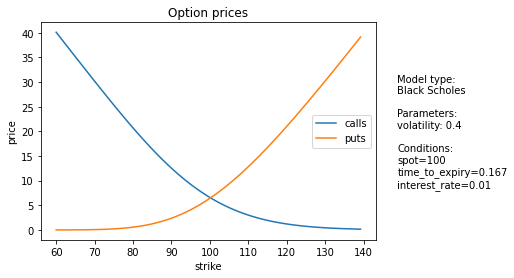

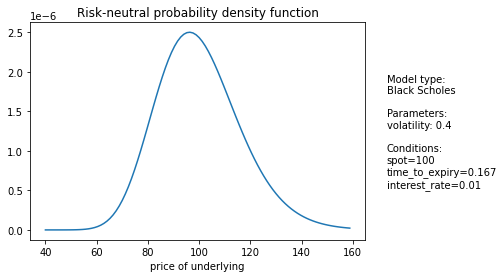

In [7]:
current_conditions = MarketConditions(spot=100, interest_rate=0.01) 
bs_model = PricingModel(
    model_name="Black Scholes", 
    params={'volatility': 0.4}, 
    conditions= current_conditions
    )
bs_model.model.volatility
#bs_model.pricing_plot(time_to_expiry=2/12, min_strike=60, max_strike=140, time_value_only=True)
bs_model.pricing_plot(time_to_expiry=2/12, min_strike=60, max_strike=140, time_value_only=False)
bs_model.probability_distribution_plot(time_to_expiry=2/12, min_strike=40, max_strike=160)
print()


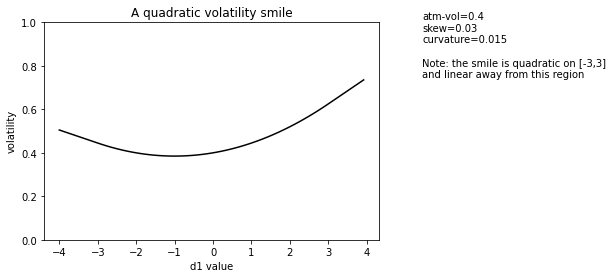

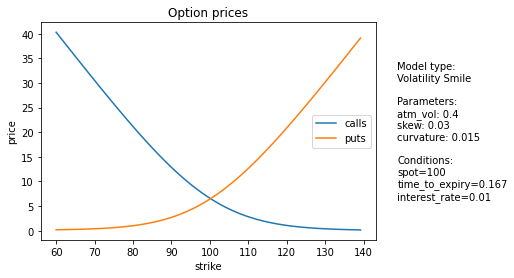

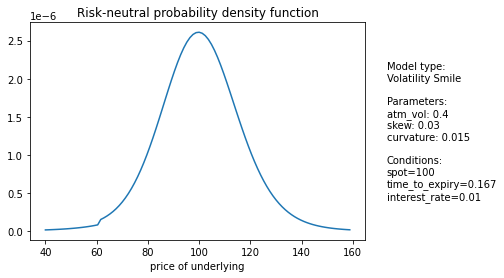

In [8]:
vs_model = PricingModel(
    model_name="Volatility Smile", 
    params={'atm_vol': 0.4, 'skew': 0.03, 'curvature': 0.015}, 
    conditions= current_conditions
    )
vs_model.model.plot_smile()
#vs_model.pricing_plot(time_to_expiry=2/12, min_strike=60, max_strike=140, time_value_only=True)
vs_model.pricing_plot(time_to_expiry=2/12, min_strike=60, max_strike=140, time_value_only=False)
vs_model.probability_distribution_plot(time_to_expiry=2/12, min_strike=40, max_strike=160)
print()

## Comparison

Finally, we compare the Black-Scholes and volatility smile pricing models

In [9]:
def compare_bs_vs(
    atm_vol: float,
    skew: float,
    curvature: float,
    bs_volatility: float,
    time_to_expiry: float,
    conditions: MarketConditions
):
    common_min_strike = 0.4*conditions.spot
    common_max_strike = 1.6*conditions.spot
    bs_model = PricingModel(
        model_name="Black Scholes", 
        params={'volatility': bs_volatility}, 
        conditions= conditions
    )
    bs_time_value_prices = bs_model.pricing_plot(
        time_to_expiry=time_to_expiry, 
        min_strike=common_min_strike, 
        max_strike=common_max_strike, 
        time_value_only=True,
        plot =False)
    bs_pdf = bs_model.probability_distribution_plot(
        time_to_expiry=time_to_expiry, 
        min_strike=common_min_strike, 
        max_strike=common_max_strike, 
        plot=False)

    vs_model = PricingModel(
        model_name="Volatility Smile", 
        params={'atm_vol': atm_vol, 'skew': skew, 'curvature': curvature}, 
        conditions= conditions
        )
    vs_time_value_prices = vs_model.pricing_plot(
        time_to_expiry=time_to_expiry, 
        min_strike=common_min_strike, 
        max_strike=common_max_strike, 
        time_value_only=True,
        plot=False)
    vs_pdf = vs_model.probability_distribution_plot(
        time_to_expiry=time_to_expiry, 
        min_strike=common_min_strike, 
        max_strike=common_max_strike,
        plot=False)
    
    fig, (ax1,ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18,5))
    ax1.plot(
        vs_time_value_prices['strikes'],
        vs_time_value_prices['call_prices'], label="Volatility smile model")
    ax1.plot(
        vs_time_value_prices['strikes'],
        bs_time_value_prices['call_prices'], label="Black-Scholes model", color="green")
    ax1.set_title("Time values for call options")
    ax1.set(xlabel="strike", ylabel ="price")
    ax1.legend()  

    ax2.plot(
        vs_time_value_prices['strikes'],
        vs_time_value_prices['put_prices'], label="Volatility smile model")
    ax2.plot(
        vs_time_value_prices['strikes'],
        bs_time_value_prices['put_prices'], label="Black-Scholes model", color="green")
    ax2.set_title("Time values for put options")
    ax2.set(xlabel="strike", ylabel ="price")
    ax2.legend()  

    ax3.plot(
        vs_pdf['strikes'],
        vs_pdf['probs'], label="Volatility smile model")
    ax3.plot(
        vs_pdf['strikes'],
        bs_pdf['probs'], label="Black-Scholes model", color="green")
    ax3.set_title("Risk-neutral distributions")
    ax3.set(xlabel="price of underlying")
    ax3.legend()  
    plt.show()

    
    

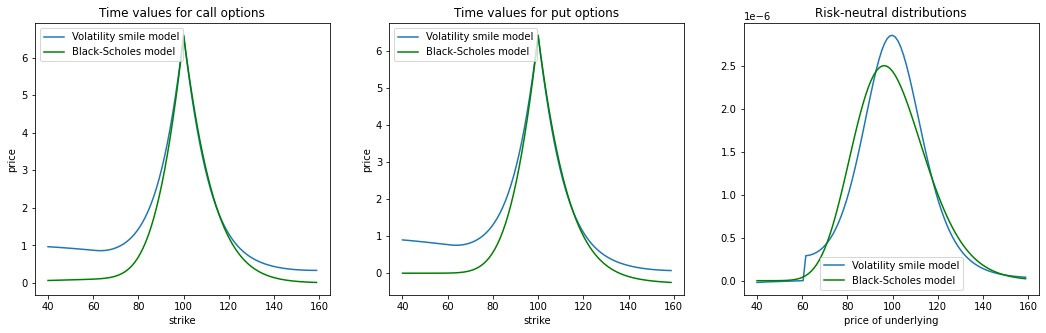

In [10]:
compare_bs_vs(
    atm_vol=0.4,
    skew=0.03,
    curvature= 0.035,
    bs_volatility=0.4,
    time_to_expiry=2/12,
    conditions=MarketConditions(spot=100, interest_rate=0.01)
)